In [2]:
!pip install pulp

In [1]:
import pulp as op
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

C:\Users\JuanLombana\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
p = np.array([1,2,3]) #precios de las variedades.
w = np.array([300,350,200]) #capacidad de siembra de los bancos.
v = np.array([150,220,300]) # cantidades de variedades disponibles para sembrar.
n = v.shape[0] #Cantidad de variedades.
m = w.shape[0] #Cantidad de camas.
L=np.array([[0,0,0]]) #Restricciones de NO compatibilidad por variedad.
Q = np.array([0,1,2]) #Distribución de camas a bloques.

In [3]:
concat = lambda t,e : str(t)+str(e)
beds = [concat(xt,xe) for xt,xe in zip(np.repeat(['Bed'],m*n),np.repeat(np.arange(1,m+1),n))]
varieties = [concat(xt,xe) for xt,xe in zip(np.repeat(['_Var'],m*n),np.tile(np.arange(1,n+1),m))]
bedsXvars = [concat(xt,xe) for xt,xe in zip(beds,varieties)]
c=dict(zip(bedsXvars, np.tile(p,m)*np.repeat(w,n)))
A=dict(zip(bedsXvars,np.repeat(w,n)))

In [4]:
prob = op.LpProblem("Plannting_plan",op.LpMaximize)
beds = op.LpVariable.dicts("BedsVar",bedsXvars,lowBound=0,upBound=1,cat=op.LpContinuous)
prob += op.lpSum([c[i]*beds[i] for i in bedsXvars]) # Función de Costo, Precio de la variedad * X

Restricción que representa la capacidad de los bancos por variedad

In [5]:
for j in np.arange(0,n):
    rTemp = np.zeros(m*n)
    for h in np.arange(0,m):
        p1 = np.zeros(j) #Cantidad de ceros adelante segun el indice de la cama
        p2 = [w[h]] #Capacidad del banco
        p3 = np.zeros(n-(j+1)) #
        rTemp[h*n:(h*n)+n]=np.concatenate((p1,p2,p3))
    r = dict(zip(bedsXvars,rTemp))
    prob += op.lpSum([r[i]*beds[i] for i in bedsXvars])<=v[j] #Restricción del área de la siembra.

Restricción que representa que solo pueda sembrarse el 100% cama como MAX

In [6]:
for k in np.arange(0,m): #Se crea un restricción por cama.
    p1 = np.zeros(k*n) #Cantidad de ceros adelante segun el indice de la cama
    p2 = np.ones(n) #Cantidad de unos que representan la restriccion
    p3 = np.zeros(((m*n)-((k*n)+n))) #cantidad de ceros al final
    r = dict(zip(bedsXvars,np.concatenate((p1,p2,p3))))
    prob += op.lpSum([r[i]*beds[i] for i in bedsXvars]) <= 1 #Restricción de máximo una variedad por cama.

In [7]:
q = np.unique(Q)
qCount = [len((Q==xq).nonzero()[0]) for xq in q]
f_zq = 0
for c_qi in np.arange(0,len(q)):
    qi=q[c_qi]
    for li in L:
        p1 = np.zeros(n*f_zq)
        p2 = np.tile(li,qCount[c_qi])
        p3 = np.zeros(n*(len(Q)-qCount[c_qi]-f_zq))
        r = dict(zip(bedsXvars,np.concatenate((p1,p2,p3))))
        prob += op.lpSum([r[i]*beds[i] for i in bedsXvars]) == 0
    f_zq += qCount[c_qi]

In [8]:
prob.solve()
print("Estado:",op.LpStatus[prob.status])
print("Objetivo:",op.value(prob.objective))
print("Vaiables:")
for va in prob.variables():
    if va.varValue>0:
        print(va.name, "=", va.varValue)

Estado: Optimal
Objetivo: 1490.0000049999999
Vaiables:
BedsVar_Bed1_Var2 = 0.56666667
BedsVar_Bed2_Var3 = 0.85714286
BedsVar_Bed3_Var1 = 0.75
BedsVar_Bed3_Var2 = 0.25


In [9]:
beds

{'Bed1_Var1': BedsVar_Bed1_Var1,
 'Bed1_Var2': BedsVar_Bed1_Var2,
 'Bed1_Var3': BedsVar_Bed1_Var3,
 'Bed2_Var1': BedsVar_Bed2_Var1,
 'Bed2_Var2': BedsVar_Bed2_Var2,
 'Bed2_Var3': BedsVar_Bed2_Var3,
 'Bed3_Var1': BedsVar_Bed3_Var1,
 'Bed3_Var2': BedsVar_Bed3_Var2,
 'Bed3_Var3': BedsVar_Bed3_Var3}

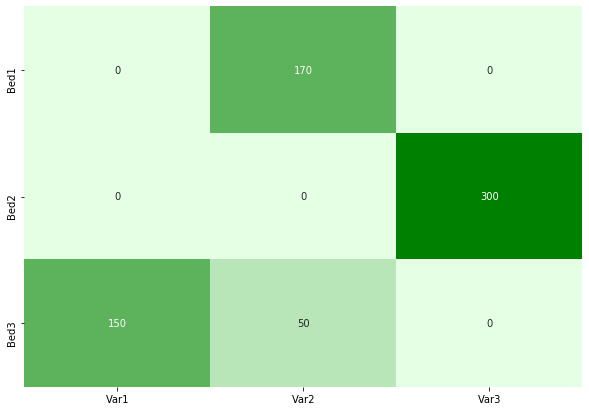

In [10]:
plantingPlan = np.around((np.array([ x.varValue for x in prob.variables()]).reshape(m,n) * np.repeat(w,n).reshape(m,n)),decimals=0)
bedsT = [concat(xt,xe) for xt,xe in zip(np.repeat(['Bed'],m),np.arange(1,m+1))]
varsT = [concat(xt,xe) for xt,xe in zip(np.repeat(['Var'],m),np.arange(1,n+1))]
df_cm = pd.DataFrame(plantingPlan,index=bedsT, columns=varsT)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,fmt='.10g',cbar=False,cmap=sns.light_palette("green"));

Cantidades de Variedades Pendientes Por Sembrar


In [660]:
v_Planted = np.sum(plantingPlan,axis=0)
v-v_Planted

array([0., 0., 0.])

Aréa disponible despues de la siembra

In [663]:
w

array([300, 350, 245])

In [664]:
w_Planted

array([125., 310., 245.])

In [661]:
w_Planted = np.sum(plantingPlan,axis=1)
w-w_Planted

array([175.,  40.,   0.])

In [647]:
prob

Plannting_plan:
MAXIMIZE
300*BedsVar_Bed1_Var1 + 600*BedsVar_Bed1_Var2 + 900*BedsVar_Bed1_Var3 + 350*BedsVar_Bed2_Var1 + 700*BedsVar_Bed2_Var2 + 1050*BedsVar_Bed2_Var3 + 245*BedsVar_Bed3_Var1 + 490*BedsVar_Bed3_Var2 + 735*BedsVar_Bed3_Var3 + 0
SUBJECT TO
_C1: 300 BedsVar_Bed1_Var1 + 350 BedsVar_Bed2_Var1 + 245 BedsVar_Bed3_Var1
 <= 150

_C2: 300 BedsVar_Bed1_Var2 + 350 BedsVar_Bed2_Var2 + 245 BedsVar_Bed3_Var2
 <= 220

_C3: 300 BedsVar_Bed1_Var3 + 350 BedsVar_Bed2_Var3 + 245 BedsVar_Bed3_Var3
 <= 310

_C4: BedsVar_Bed1_Var1 + BedsVar_Bed1_Var2 + BedsVar_Bed1_Var3 <= 1

_C5: BedsVar_Bed2_Var1 + BedsVar_Bed2_Var2 + BedsVar_Bed2_Var3 <= 1

_C6: BedsVar_Bed3_Var1 + BedsVar_Bed3_Var2 + BedsVar_Bed3_Var3 <= 1

_C7:0 = 0

_C8:0 = 0

_C9:0 = 0

VARIABLES
BedsVar_Bed1_Var1 <= 1 Continuous
BedsVar_Bed1_Var2 <= 1 Continuous
BedsVar_Bed1_Var3 <= 1 Continuous
BedsVar_Bed2_Var1 <= 1 Continuous
BedsVar_Bed2_Var2 <= 1 Continuous
BedsVar_Bed2_Var3 <= 1 Continuous
BedsVar_Bed3_Var1 <= 1 Continuous
BedsV